In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import platform
import nltk
import numpy as np
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
import konlpy
from konlpy.tag import Komoran
from collections import Counter

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin' :
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows' :
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else :
    print('Unknown system...')

In [14]:
df = pd.read_excel('20190503 Sample_Data_OSP.xlsx')
# df = pd.read_csv('20190503 Sample_Data_OSP_W_Keywords.csv', sep = ',', encoding = 'utf-8')

In [4]:
del df['Index']

### 1. 기본 정보 확인

#### 컬럼 별 데이터 변수 확인

텍스트 : '과제명_국문', '요약문_기대효과', '요약문_연구내용', '요약문_연구목표', '요약문_영문키워드', '요약문_한글키워드'

범주 : '과제수행년도', '구부처명', '부처명', '신규계속구분', '연구개발단계', '지역', '총연구기간_시작년월일', '총연구기간_종료년월일', '산업부여부'

연속 : 정부출연금_천원

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17039 entries, 0 to 17038
Data columns (total 17 columns):
과제명_국문         17039 non-null object
과제수행년도         17039 non-null int64
구부처명           16236 non-null object
부처명            17039 non-null object
사업명            17039 non-null object
신규계속구분         17039 non-null object
연구개발단계         16236 non-null object
요약문_기대효과       16987 non-null object
요약문_연구내용       16987 non-null object
요약문_연구목표       16976 non-null object
요약문_영문키워드      16985 non-null object
요약문_한글키워드      16985 non-null object
정부출연금_천원       17039 non-null float64
지역             17039 non-null object
총연구기간_시작년월일    17039 non-null object
총연구기간_종료년월일    17039 non-null object
산업부여부          17039 non-null object
dtypes: float64(1), int64(1), object(15)
memory usage: 2.2+ MB


In [6]:
category_columns = ['과제수행년도', '구부처명', '부처명', 
                    '신규계속구분', '연구개발단계', '지역', 
                    '총연구기간_시작년월일', '총연구기간_종료년월일', '산업부여부']

for category in category_columns :
    print('----------------------------------')
    print(category)
    print(df[category].value_counts())

----------------------------------
과제수행년도
2013    11236
2014     3415
2015     1192
2017      803
2016      393
Name: 과제수행년도, dtype: int64
----------------------------------
구부처명
중소기업청    7117
None     5241
지식경제부    3876
외교통상부       2
Name: 구부처명, dtype: int64
----------------------------------
부처명
산업통상자원부      8242
중소기업청        8176
과학기술정보통신부     621
Name: 부처명, dtype: int64
----------------------------------
신규계속구분
계속    8874
신규    8165
Name: 신규계속구분, dtype: int64
----------------------------------
연구개발단계
개발연구    13038
기타       1432
응용연구     1057
기초연구      709
Name: 연구개발단계, dtype: int64
----------------------------------
지역
경기도        3685
서울특별시      3107
대전광역시      1514
경상북도        988
대구광역시       950
부산광역시       924
경상남도        917
충청남도        911
충청북도        660
전라북도        653
인천광역시       574
광주광역시       566
강원도         475
전라남도        437
울산광역시       341
제주특별자치도     151
기타          135
세종특별자치시      32
해외           19
Name: 지역, dtype: int64
----------------------------------
총연구기간_시

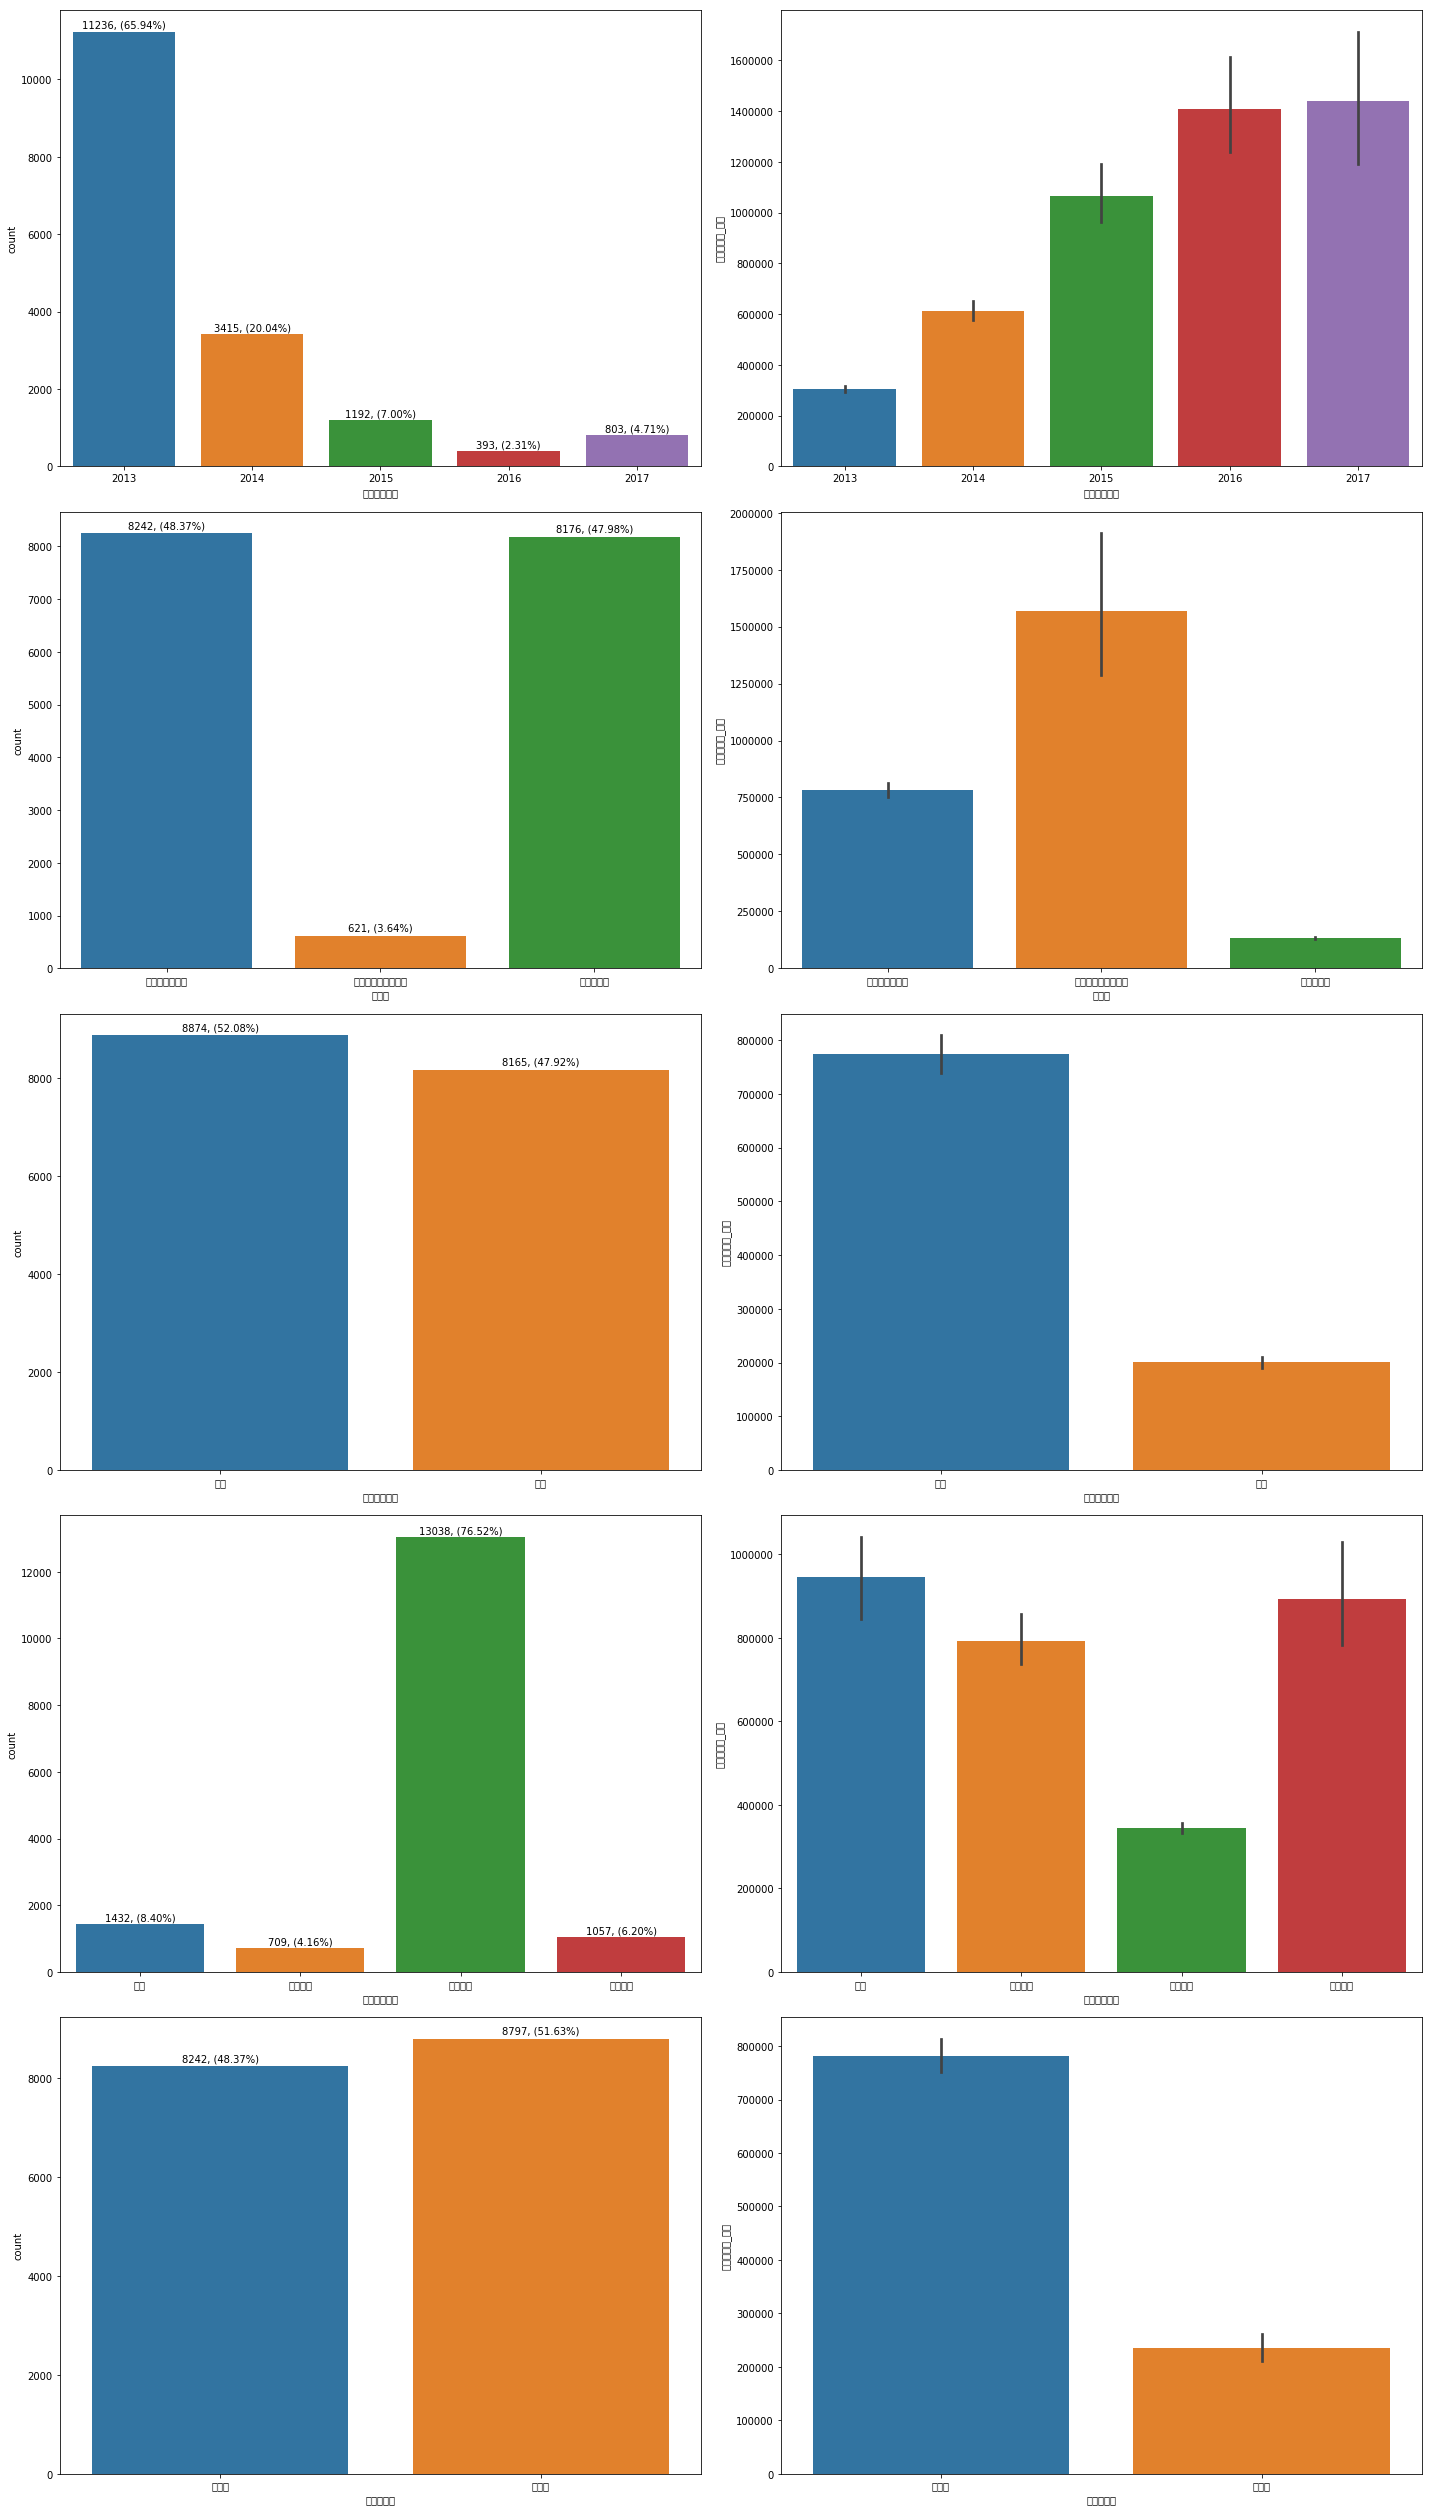

In [7]:
# ppt 1. 현황분석 (슬라이드 pg. 4-7)
  
category_columns = ['과제수행년도', '부처명', '신규계속구분', '연구개발단계', '산업부여부']

fig, ax = plt.subplots(5, 2, figsize=(20,35))
total = float(len(df))
for i, category in enumerate(category_columns) :
    sns.countplot(x = category, data = df, ax = ax[i][0])
    sns.barplot(x=category, y='정부출연금_천원', data=df, ax=ax[i][1])
    for p in ax[i][0].patches:
        height = p.get_height()
        ax[i][0].text(p.get_x()+p.get_width()/2.,
            height + 100,
            '{}, ({:1.2f}%)'.format(height, height/total*100),
            ha="center")
        ax[i]
    plt.tight_layout()

### 요약문_한글키워드 결측치 처리 

In [10]:
def komoran_title(_str) :
    p = re.compile('NN*')
    komoran = Komoran()
    komoran_morphs = komoran.pos(str(_str))
    return_list = [x[0] for x in komoran_morphs if p.search(x[1])]
    return_string = ''
    for x in return_list :
        return_string = return_string + x + ', '
    print(_str)
    print(return_string.strip()[:-1])
    print('-------------------------')
    return return_string.strip()[:-1]

In [11]:
for i in df[df['요약문_한글키워드'].isnull()].index :
    df.loc[i, ['요약문_한글키워드']] = komoran_title(df.loc[i, ['과제명_국문']]['과제명_국문'])

for i, x in enumerate(df['요약문_한글키워드']) :
    if df.loc[i, ['요약문_한글키워드']]['요약문_한글키워드'] == '0' or df.loc[i, ['요약문_한글키워드']]['요약문_한글키워드'] == 'None' :
        df.loc[i, ['요약문_한글키워드']] = komoran_title(df.loc[i, ['과제명_국문']]['과제명_국문'])

방사선의학 임상적용 및 지역협력 기반구축사업
방사선, 의학, 임상, 적용, 지역, 협력, 기반, 구축, 사업
-------------------------
인건비
인건비
-------------------------
경상경비
경상, 경비
-------------------------
학술정보관운영
학술, 정보, 관, 운영
-------------------------
교육연구기자재운영
교육, 연구, 기자재, 운영
-------------------------
프로그램 운영비
프로그램, 운영비
-------------------------
시스템산업기술개발기반구축사업 평가관리비
시스템, 산업, 기술, 개발, 기반, 구축, 사업, 평가, 관리비
-------------------------
장비시스템구축
장비, 시스템, 구축
-------------------------
정보통신방송표준개발지원 평가관리비
정보통신, 방송, 표준, 개발, 지원, 평가, 관리비
-------------------------
중이온가속기구축사업 기획평가관리비
중, 이온, 가속기, 구축, 사업, 기획, 평가, 관리비
-------------------------
산업정책연구
산업, 정책, 연구
-------------------------
시설비
시설비
-------------------------
창조경제 실현을 위한 교육프로그램 개발 운영 사업
창조경제, 실현, 교육, 프로그램, 개발, 운영, 사업
-------------------------
기초과학연구원 인건비 사업
기초과학연구원, 인건비, 사업
-------------------------
과학기술인력 온라인 교육 사업
과학기술, 인력, 온라인, 교육, 사업
-------------------------
글로벌선도대학육성
글로벌, 선도, 대학, 육성
-------------------------
차세대태양전지기술개발운영
차세대, 태양, 전지, 기술, 개발, 운영
-------------------------
기초과학연구원 경상경

평가관리비
평가, 관리비
-------------------------
기술표준전문강좌운영 평가관리
기술, 표준, 전문, 강좌, 운영, 평가, 관리
-------------------------
산업전문인력역량강화사업 총괄기획평가관리
산업, 전문, 인력, 역량, 강화, 사업, 총괄, 기획, 평가, 관리
-------------------------
디스플레이산업 인적자원개발협의체활성화 지원
디스플레이, 산업, 인적, 자원, 개발, 협의체, 활성, 화, 지원
-------------------------
고급연구인력활용지원사업(전담)
고급, 연구, 인력, 활용, 지원, 사업, 전담
-------------------------
바이오전문인력양성 평가관리
바이오, 전문, 인력, 양성, 평가, 관리
-------------------------
평가관리비
평가, 관리비
-------------------------
산업전문인력역량강화 사업평가관리
산업, 전문, 인력, 역량, 강화, 사업, 평가, 관리
-------------------------
평가관리비
평가, 관리비
-------------------------
평가관리비
평가, 관리비
-------------------------
평가관리비
평가, 관리비
-------------------------
해외장학
해외, 장학
-------------------------
평가관리비
평가, 관리비
-------------------------
기획평가관리비
기획, 평가, 관리비
-------------------------
자원개발특성화대학
자원, 개발, 특, 성화대학
-------------------------
평가관리비
평가, 관리비
-------------------------
평가관리비
평가, 관리비
-------------------------
평가관리비
평가, 관리비
-------------------------
평가관리비
평가, 관리비
-------------------------
평가관리비
평가, 

고고도장기체공시범기 기술개발 과제관리 및 평가
고고, 도장, 기체, 공시, 범기, 기술, 개발, 과제, 관리, 평가
-------------------------
에너지정보 통계시스템 선진화 방안 연구
에너지, 정보, 통계, 시스템, 선진, 화, 방안, 연구
-------------------------
유가스전개발 현장연계 R&d 추진전략
유, 가스, 전, 개발, 현장, 연계, 추진, 전략
-------------------------
온실가스·에너지 목표관리제도 개선방안 연구
온실, 가스, 에너지, 목표, 관리제, 개선, 방안, 연구
-------------------------


In [12]:
len(df[(df['요약문_한글키워드'].isnull()) | (df['요약문_한글키워드'] == '0')])

0

### 텍스트 데이터 통합문서 열 추가

row 별 아래 텍스트를 하나의 문헌으로 통합 후 분석

텍스트 : '과제명_국문', '요약문_기대효과', '요약문_연구내용', '요약문_연구목표', '요약문_영문키워드', '요약문_한글키워드'

In [15]:
def merge_text(df) :
#     f = open('텍스트처리.txt', 'w', encoding = 'utf-8')
#     columns = ['과제명_국문', '요약문_기대효과', '요약문_연구내용', '요약문_연구목표', '요약문_영문키워드', '요약문_한글키워드']
    columns = ['과제명_국문', '요약문_연구내용', '사업명','요약문_한글키워드']
    return_list = list()
    for i in range(len(df)) :
        tmp_string = ''
        tmp_list = list()
        for column in columns :
            try :
                tmp_string += df.loc[i, column].replace('\n', '').strip() + ' '
            except :
                continue
#         f.write(tmp_string)
        tmp_list.append(tmp_string)
        return_list.append(tmp_list)
#     f.close()
    return return_list

In [16]:
df['통합문서'] = merge_text(df)

### 워드클라우드

In [13]:

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform

In [14]:
path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin' :
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows' :
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else :
    print('Unknown system...')

%matplotlib inline

Unknown system...


### 명사 추출 + 불용어 제거 프로세스

In [2]:
def process(corpus, stopword_file = None):
    komoran = konlpy.tag.Komoran()
    result = []
    if stopword_file != None:
        stopwords = set([line.strip() for line in open(stopword_file, encoding='utf-8').readlines()])
        for line in corpus:
            result.append([i for i in komoran.nouns(re.sub(r'[^\d\s\w]', ' ', line.strip())) if i not in stopwords])
    else:
        for line in corpus:
            result.append(komoran.nouns(re.sub(r'[^\d\s\w]', ' ', line.strip())))
    return result

#### 연도별 워드클라우드

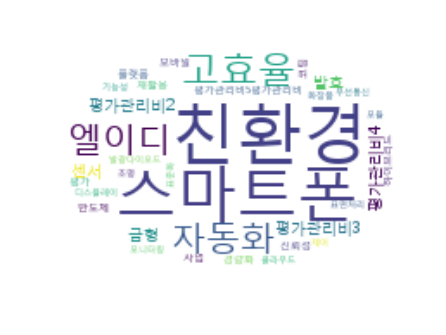

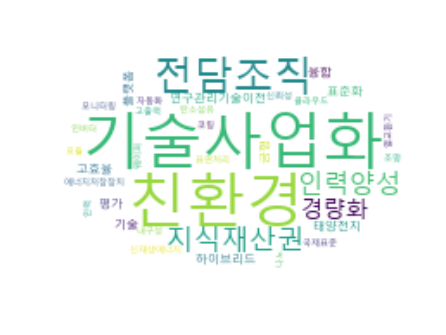

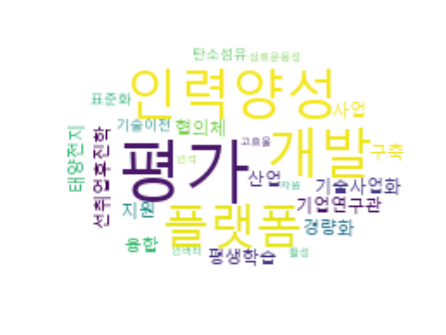

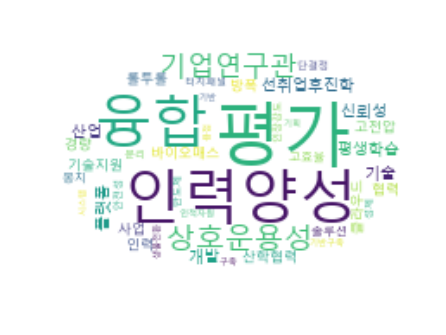

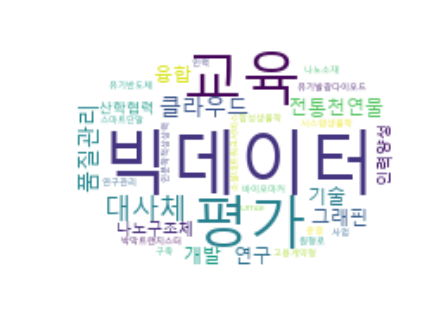

In [16]:
# ppt 2. 키워드추출 (슬라이드 pg. 9-12)
years = [2013,2014,2015,2016,2017]
for year in years :
    tmp = df[df['과제수행년도'] == year]
    text = ''
    for i in tmp.index:
        try:
            text += ' '.join(re.sub(r'\d\.', '', tmp['요약문_한글키워드'][i]).replace(' ', '').split(','))
        except:
            pass
    
    _mask = np.array(Image.open('oval.png'))
    
    wc = WordCloud(collocations=False, background_color = 'white', max_words = 200, mask = _mask, min_font_size=5, font_path = "c:/Windows/Fonts/malgun.ttf", relative_scaling = 0.2)
    wc = wc.generate(text)
    wc.words_
    
    plt.figure(figsize = (6, 6))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(str(year) + '.png')

#### 부처별 워드클라우드

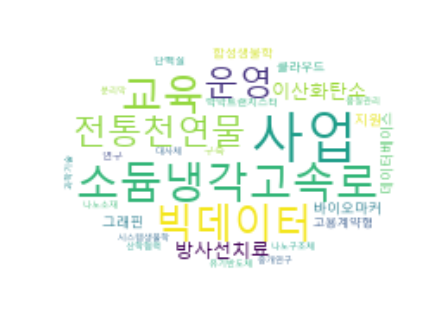

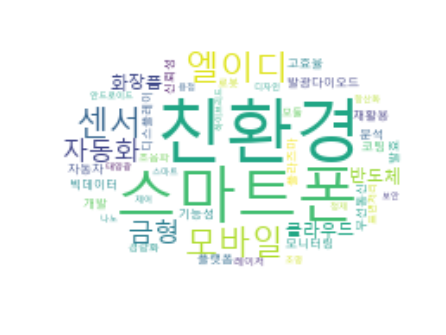

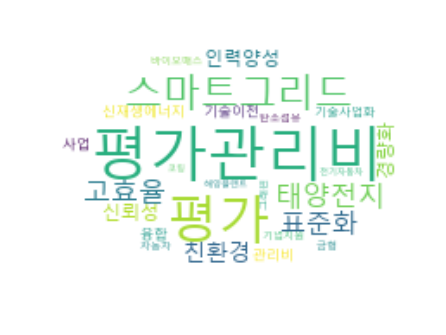

In [35]:
locations = ['과학기술정보통신부','중소기업청','산업통상자원부']
for location in locations :
    tmp = df[df['부처명'] == location]
    text = ''
    for i in tmp.index:
        try:
            text += ' '.join(re.sub(r'\d\.', '', tmp['요약문_한글키워드'][i]).replace(' ', '').split(',')) + ' '
        except:
            pass
    text = re.sub(r'평가관리비', ' 평가관리비 ', text)
    
    _mask = np.array(Image.open('oval.png'))
    
    wc = WordCloud(collocations=False, background_color = 'white', max_words = 200, mask = _mask, min_font_size=5, font_path = "c:/Windows/Fonts/malgun.ttf", relative_scaling = 0.2)
    wc = wc.generate(text)
    wc.words_
    
    plt.figure(figsize = (6, 6))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(location + '.png')

### 2. 텍스트 데이터 처리

row 별 아래 텍스트를 하나의 문헌으로 통합 후 분석

텍스트 : '과제명_국문', '요약문_기대효과', '요약문_연구내용', '요약문_연구목표', '요약문_영문키워드', '요약문_한글키워드'

K-Means를 통한 문서 군집화 확인

In [19]:
f = open('텍스트처리.txt', 'w', encoding = 'utf-8')
for i in range(len(df)) :
    string = str(df.loc[i, '통합문서']).replace('[', '').replace(']', '')
    f.write(string)
    f.write('\n')
f.close()

In [3]:
with open('텍스트처리.txt', encoding='utf=8') as f:
        corpus = f.readlines()

In [4]:
result = process(corpus, 'stopwordsKor.txt')

In [5]:
converted_docs = []
for doc in result :
    new_doc = ''
    new_doc += " ".join(doc)
    converted_docs.append(new_doc)

In [6]:
cv=CountVectorizer(max_df=0.85, max_features=10000)
word_count_vector=cv.fit_transform(converted_docs)

In [7]:
#generate tf-idf for the given document set
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tf_idf_matrix = tfidf_transformer.fit_transform(word_count_vector)
# you only needs to do this once, this is a mapping of index to
feature_names=cv.get_feature_names()

In [8]:
dense = tf_idf_matrix.todense()

문헌 별 TFIDF값 확인

In [9]:
f = open("TFIDF_result.txt", 'w', encoding = 'utf-8')
for i in range(len(dense)) :
    f.write('----------------------------------------------------')
    f.write('\n')
    f.write('문헌번호 : {}'.format(i))
    f.write('\n')
    doc = dense[i].tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len(doc)), doc) if pair[1] > 0]
    if len(phrase_scores) > 4 :
        sorted_words = sorted(phrase_scores, key=lambda t: t[1] * -1)
        sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)[:10]
        for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores] :
            f.write('{0: <20} {1}'.format(phrase, score))
            f.write('\n')
f.close()

In [10]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

X = dense
NUM_CLUSTERS = 10
kmeans = KMeans(n_clusters=NUM_CLUSTERS, max_iter = 10, verbose=1)
predict = kmeans.fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 16267.752953936011
start iteration
done sorting
end inner loop
Iteration 1, inertia 16072.491636167555
start iteration
done sorting
end inner loop
Iteration 2, inertia 16023.01439418404
start iteration
done sorting
end inner loop
Iteration 3, inertia 16006.946736267606
start iteration
done sorting
end inner loop
Iteration 4, inertia 15999.612521579476
start iteration
done sorting
end inner loop
Iteration 5, inertia 15995.75940104774
start iteration
done sorting
end inner loop
Iteration 6, inertia 15992.936387876647
start iteration
done sorting
end inner loop
Iteration 7, inertia 15990.818281872567
start iteration
done sorting
end inner loop
Iteration 8, inertia 15989.660587672253
start iteration
done sorting
end inner loop
Iteration 9, inertia 15989.04885699128
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 16280.44093873027
start iteration
done sorting
end

Iteration 5, inertia 16032.04247248722
start iteration
done sorting
end inner loop
Iteration 6, inertia 16017.058566908298
start iteration
done sorting
end inner loop
Iteration 7, inertia 16008.585336966438
start iteration
done sorting
end inner loop
Iteration 8, inertia 16001.223821671363
start iteration
done sorting
end inner loop
Iteration 9, inertia 15995.828474148628


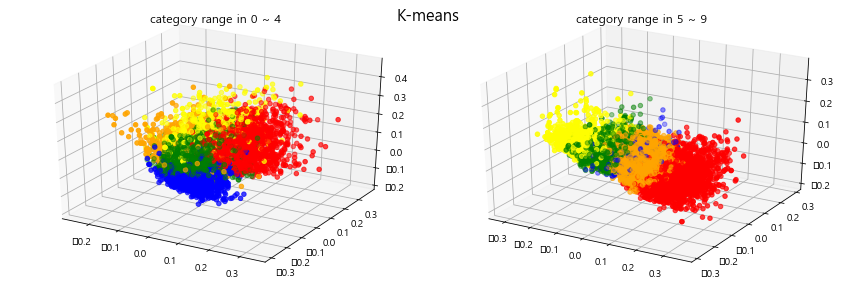

In [11]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

pca1 = PCA(n_components=3)
X_low = pca1.fit_transform(X)

df = pd.DataFrame(X_low)
df['category_k'] = predict.labels_

fig = plt.figure(figsize=(12, 8))
fig.suptitle('K-means', fontsize=16)
loc = 1
for i in range(2) :
    colormap = {0+i*5 : 'red',
               1+i*5 : 'green',
               2+i*5 : 'blue',
               3+i*5 : 'yellow',
               4+i*5 : 'orange'}
    tmp_df = pd.DataFrame(df.loc[(df['category_k'] >= i*5) & (df['category_k'] < (i+1)*5)])
    colors = tmp_df.apply(lambda row: colormap[row.category_k], axis=1)
    ax = fig.add_subplot(2, 2, loc, projection='3d')
    ax.scatter(tmp_df[0], tmp_df[1], tmp_df[2], c=colors, marker='o')
    loc += 1
    ax.set_title('category range in {} ~ {}'.format(0+i*5, i*5+len(tmp_df['category_k'].unique())-1))
    plt.tight_layout()
# ax = df.plot(kind='scatter', x=0, y=1, z=2, alpha=0.1, c=colors)

# ax.view_init(105, 315)

### 3. 키워드 추출 

In [12]:
def is_in_dict(x, column) :
    key_dict = dict()
    key_dict['에너지'] = ['에너지','전지','발전기','태양','풍력','원자력','화력','배터리']
    key_dict['바이오'] = ['신체','노화', '박테리아', '효소','체온','미생물','생체','바이오','건강','헬스케어','항산화','항노화','항염증','줄기세포','의료기기']
    key_dict['정보통신'] = ['데이터','모바일','클라우드','스마트폰','플랫폼','증강현실','무선통신','보안','센서','안드로이드','네트워크','블루투스','어플리케이션','가상화','와이파이','사물통신','소프트웨어','영상처리']
    key_dict['화학/신소재'] = ['약품','가스','이온','화장품','액화천연가스','나노소재','플라스틱','섬유','박막','발광다이오드','알루미늄','반도체','세라믹','플라즈마','폴리우레탄']
    key_dict['디스플레이'] = ['스마트그리드','디스플레이','엘이디','조명','에너지저장장치']
    key_dict['시스템'] = ['공정','인력양성','기업지원','산학협력','인적자원','인력수급']
    key_dict['기계공학'] = ['부품','성형','조선','자동차','로봇','금형','사출','압출','항공기','자동화']
    key_dict['환경'] = ['대기','폐기','천연','환경','하이브리드','재활용']
    key_dict['기타'] = ['경비','학술','운영비','선박','수출','수입','관리비','해양','디자인','교육','인건비']

#     for element in x :
#         x_list = str(x).replace(' ','').split(',')
#         for item in x_list :
#             if item in key_dict.get(column) :
#                 return 1
#             else :
#                 continue
    for key in key_dict[column]:
        if key in ''.join(x):
            return 1
    return 0

In [17]:
df['에너지'] = df['통합문서'].apply(lambda x : is_in_dict(x, '에너지'))
df['바이오'] = df['통합문서'].apply(lambda x : is_in_dict(x, '바이오'))
df['정보통신'] = df['통합문서'].apply(lambda x : is_in_dict(x, '정보통신'))
df['화학/신소재'] = df['통합문서'].apply(lambda x : is_in_dict(x, '화학/신소재'))
df['디스플레이'] = df['통합문서'].apply(lambda x : is_in_dict(x, '디스플레이'))
df['시스템'] = df['통합문서'].apply(lambda x : is_in_dict(x, '시스템'))
df['기계공학'] = df['통합문서'].apply(lambda x : is_in_dict(x, '기계공학'))
df['환경'] = df['통합문서'].apply(lambda x : is_in_dict(x, '환경'))
df['기타'] = df['통합문서'].apply(lambda x : is_in_dict(x, '기타'))

In [19]:
category = ['에너지', '바이오', '정보통신', '화학/신소재', '디스플레이', '시스템', '기계공학', '환경', '기타']
for column in category :
    print(df[column].value_counts())

0    13238
1     3801
Name: 에너지, dtype: int64
0    14797
1     2242
Name: 바이오, dtype: int64
0    11314
1     5725
Name: 정보통신, dtype: int64
0    12188
1     4851
Name: 화학/신소재, dtype: int64
0    15759
1     1280
Name: 디스플레이, dtype: int64
0    10876
1     6163
Name: 시스템, dtype: int64
0    11194
1     5845
Name: 기계공학, dtype: int64
0    12035
1     5004
Name: 환경, dtype: int64
0    13308
1     3731
Name: 기타, dtype: int64


키워드 미분류 데이터 기타로 처리

In [20]:
df.loc[(df['에너지'] == 0) &
        (df['바이오'] == 0) &
        (df['정보통신'] == 0) &
        (df['화학/신소재'] == 0) &
        (df['디스플레이'] == 0) &
        (df['시스템'] == 0) &
        (df['기계공학'] == 0) &
        (df['환경'] == 0) &
        (df['기타'] == 0), '기타'] = 1

전처리 후 데이터 csv로 저장

In [21]:
df.to_csv('20190503 Sample_Data_OSP_F.csv', sep = ',', encoding = 'utf-8', index_label=False)

카테고리 별 현황(개수)

카테고리 별 정부출연금 평균, 합

In [22]:
# ppt 3. 카테고리 과제 분류 (슬라이드 pg. 14-18)
df_melt = df.melt(value_vars=['에너지', '바이오', '정보통신', '화학/신소재', '디스플레이', '시스템', '기계공학', '환경', '기타'])

사업 영역 별 데이터 수

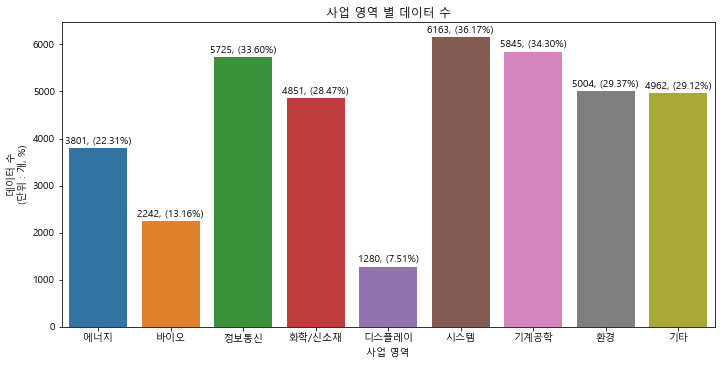

In [23]:
fig, ax = plt.subplots(figsize = (10,5))
sns.countplot(data=df_melt.loc[df_melt['value']==1], x="variable", ax = ax)

total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
        height + 100,
        '{}, ({:1.2f}%)'.format(height, height/total*100),
        ha="center")
plt.tight_layout()
plt.xlabel('사업 영역')
plt.ylabel('데이터 수\n(단위 : 개, %)')
plt.title('사업 영역 별 데이터 수')
plt.show()

사업 영역 별 연간 평균 정부출연금

In [24]:
years = [2013, 2014, 2015, 2016, 2017]
categories = ['에너지', '바이오', '정보통신', '화학/신소재', '디스플레이', '시스템', '기계공학', '환경', '기타']
df_des = pd.DataFrame()
for category in categories :
    tmp_list = list()
    gf = df.groupby(['과제수행년도', category])['정부출연금_천원']
    for year in years :
        tmp_list.append(int(gf.get_group((year,1)).mean()))
    df_des[category] = tmp_list

In [25]:
df_des['sum'] = df_des[list(df_des.columns)].sum(axis=1)

In [26]:
df_des.rename(index={0:'2013',1:'2014',2:'2015',3:'2016',4:'2017'}, inplace=True)

In [27]:
df_des = df_des.append(df_des.agg(['sum', 'mean']))

In [28]:
categories = ['에너지', '바이오', '정보통신', '화학/신소재', '디스플레이', '시스템', '기계공학', '환경', '기타']
category_list = []
money_list = []
for category in categories:
    category_list += [category] * len(df[df[category] == 1])
    money_list += list(df[df[category] == 1]['정부출연금_천원'])
new_df = pd.DataFrame({'카테고리':category_list, '정부출연금_천원':money_list})

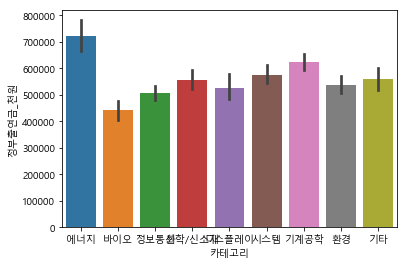

In [29]:
sns.barplot(x='카테고리', y='정부출연금_천원', data=new_df)

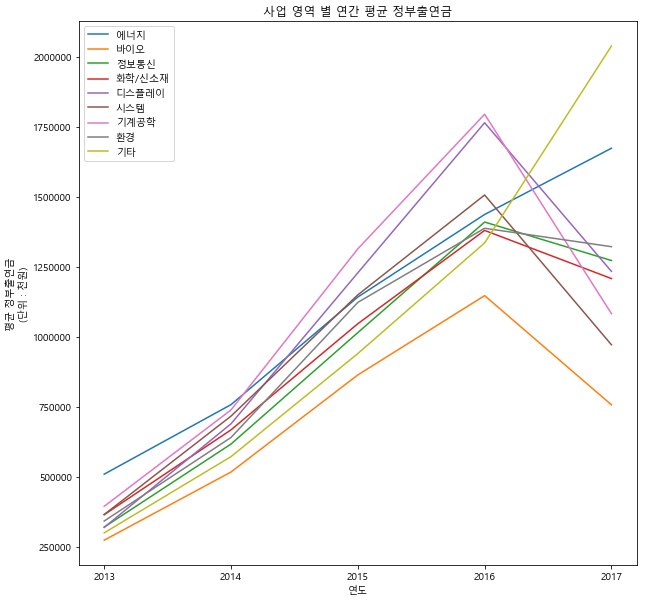

In [30]:
categories = ['에너지', '바이오', '정보통신', '화학/신소재', '디스플레이', '시스템', '기계공학', '환경', '기타']
fig, ax = plt.subplots(figsize=(10,10))
for category in categories :
    sns.lineplot(x=df_des.index.tolist()[0:5], y=category, data=df_des[0:5], label = category)
ax.legend()
plt.xlabel('연도')
plt.ylabel('평균 정부출연금\n(단위 : 천원)')
plt.title('사업 영역 별 연간 평균 정부출연금')
plt.legend()

엑셀 저장

In [31]:
df_des_transposed = df_des.T
df_des_transposed.to_excel('사업영역 별 정부출연금.xlsx',index_label=False)